In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from keras.utils import to_categorical
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTENC
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from keras.optimizers import *

# Utilitas
import os
import joblib
from google.colab import drive
from google.colab import files

import missingno as msno
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# Data

In [11]:
drive.mount('/content/drive')
googleDrivePath = "/content/drive/MyDrive/Colab_Notebooks/Dataset/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data_train = pd.read_csv(googleDrivePath + "Dataset yang digunakan untuk melatih seluruh model/Data_train.csv")
data_test = pd.read_csv(googleDrivePath + "Dataset yang digunakan untuk melatih seluruh model/Data_test.csv")

In [13]:
frames = [data_train, data_test]

df = pd.concat(frames)

In [24]:
like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) > 10]
cols_need_scale = [col for col in df.columns if col not in like_num
                   and col not in 'esi']

print('like_num: ', like_num)
print("cols_need_scale: ", cols_need_scale)

like_num:  ['age', 'triage_vital_hr', 'triage_vital_sbp', 'triage_vital_dbp', 'triage_vital_rr', 'triage_vital_o2', 'triage_vital_temp']
cols_need_scale:  ['gender_Male', 'triage_vital_o2_device_1.0', 'cc_abdominalcramping_1.0', 'cc_abdominaldistention_1.0', 'cc_abdominalpain_1.0', 'cc_abdominalpainpregnant_1.0', 'cc_abnormallab_1.0', 'cc_abscess_1.0', 'cc_addictionproblem_1.0', 'cc_agitation_1.0', 'cc_alcoholintoxication_1.0', 'cc_alcoholproblem_1.0', 'cc_allergicreaction_1.0', 'cc_alteredmentalstatus_1.0', 'cc_animalbite_1.0', 'cc_ankleinjury_1.0', 'cc_anklepain_1.0', 'cc_anxiety_1.0', 'cc_arminjury_1.0', 'cc_armpain_1.0', 'cc_armswelling_1.0', 'cc_assaultvictim_1.0', 'cc_asthma_1.0', 'cc_backpain_1.0', 'cc_bleeding/bruising_1.0', 'cc_blurredvision_1.0', 'cc_bodyfluidexposure_1.0', 'cc_breastpain_1.0', 'cc_breathingdifficulty_1.0', 'cc_breathingproblem_1.0', 'cc_burn_1.0', 'cc_cardiacarrest_1.0', 'cc_cellulitis_1.0', 'cc_chestpain_1.0', 'cc_chesttightness_1.0', 'cc_chills_1.0', 'cc_c

In [25]:
# Buat salinan dari DataFrame untuk menjaga data asli tetap aman
df_copy = df.copy()

# Buat kolom 'ESI' yang baru dengan nilai default
df_copy['level_esi'] = 0

# Update nilai 'ESI' berdasarkan nilai class_0 hingga class_4
df_copy.loc[df_copy['class_0'] > 0, 'level_esi'] = 1
df_copy.loc[df_copy['class_1'] > 0, 'level_esi'] = 2
df_copy.loc[df_copy['class_2'] > 0, 'level_esi'] = 3
df_copy.loc[df_copy['class_3'] > 0, 'level_esi'] = 4
df_copy.loc[df_copy['class_4'] > 0, 'level_esi'] = 5

# Hapus kolom class_0 hingga class_4 setelah ESI terbentuk
df_copy.drop(columns=['class_0', 'class_1', 'class_2', 'class_3', 'class_4'], inplace=True)

In [26]:
df_copy.rename(columns=lambda x: x.replace('_1.0', ''), inplace=True)

RobustScaler = joblib.load(googleDrivePath + 'Save_Model_ETC/Joblib_RobustScaler.pkl')
df_copy[like_num] = RobustScaler.inverse_transform(df_copy[like_num])

df_copy[like_num] = df_copy[like_num].astype(int)

# EDA

In [27]:
df_copy.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 508705 entries, 0 to 50870
Data columns (total 210 columns):
 #    Column                                   Non-Null Count   Dtype
---   ------                                   --------------   -----
 0    age                                      508705 non-null  int64
 1    triage_vital_hr                          508705 non-null  int64
 2    triage_vital_sbp                         508705 non-null  int64
 3    triage_vital_dbp                         508705 non-null  int64
 4    triage_vital_rr                          508705 non-null  int64
 5    triage_vital_o2                          508705 non-null  int64
 6    triage_vital_temp                        508705 non-null  int64
 7    gender_Male                              508705 non-null  int64
 8    triage_vital_o2_device                   508705 non-null  int64
 9    cc_abdominalcramping                     508705 non-null  int64
 10   cc_abdominaldistention                   508705 

In [28]:
df_copy[like_num].describe().T

,count,mean,std,min,25%,50%,75%,max
age,508705.0,49.766635,19.465066,18.0,33.0,49.0,64.0,107.0
triage_vital_hr,508705.0,86.081802,17.824495,30.0,74.0,84.0,96.0,280.0
triage_vital_sbp,508705.0,133.572552,22.364476,51.0,119.0,132.0,146.0,312.0
triage_vital_dbp,508705.0,80.145872,14.554277,24.0,71.0,80.0,89.0,189.0
triage_vital_rr,508705.0,17.864025,2.842696,8.0,16.0,18.0,18.0,69.0
triage_vital_o2,508705.0,96.909254,2.656973,60.0,96.0,98.0,98.0,99.0
triage_vital_temp,508705.0,97.598805,0.836779,90.0,97.0,98.0,98.0,106.0


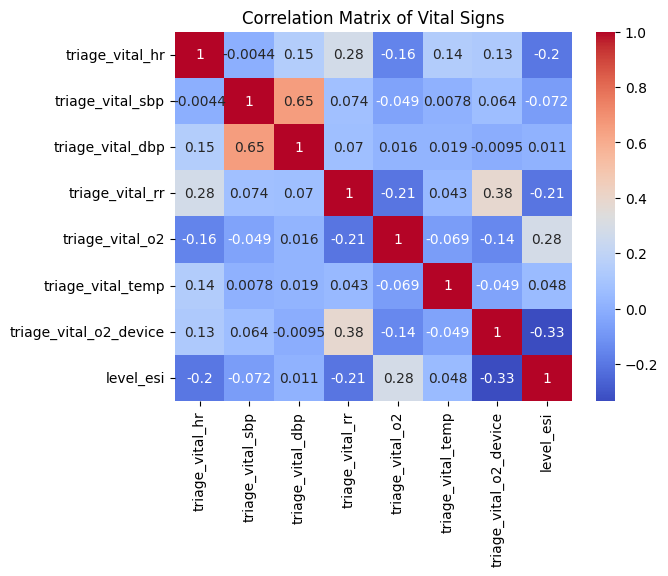

In [29]:
correlation_matrix = df_copy[['triage_vital_hr', 'triage_vital_sbp', 'triage_vital_dbp', 'triage_vital_rr', 'triage_vital_o2', 'triage_vital_temp', 'triage_vital_o2_device', 'level_esi']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Vital Signs')
plt.show()

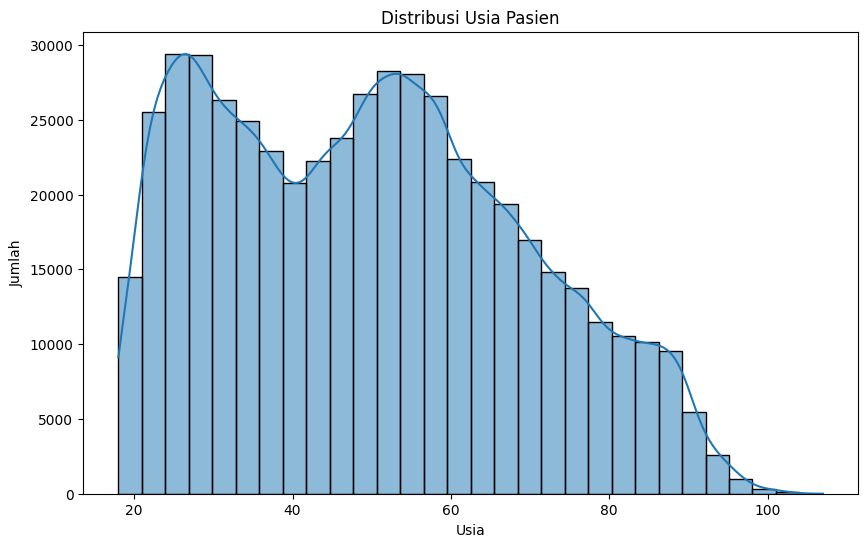

In [31]:
# 1. Distribusi Usia
plt.figure(figsize=(10, 6))
sns.histplot(df_copy['age'], bins=30, kde=True)
plt.title('Distribusi Usia Pasien')
plt.xlabel('Usia')
plt.ylabel('Jumlah')
plt.show()

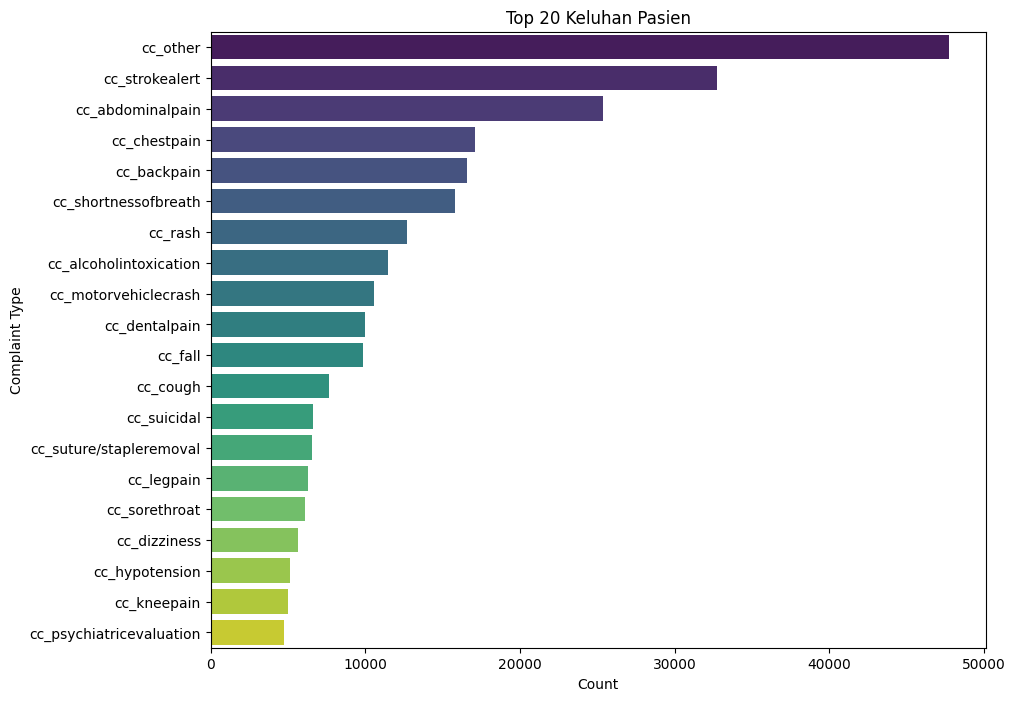

In [32]:
# Hitung frekuensi keluhan
cc_columns = [col for col in df_copy.columns if col.startswith('cc_')]
cc_summary = df_copy[cc_columns].sum().sort_values(ascending=False)

# Pilih top 20 keluhan teratas
top_n = 20
cc_top_n = cc_summary.head(top_n)
diagram_title = 'Top ' + str(top_n) + ' Keluhan Pasien'
# Plot
plt.figure(figsize=(10,8))
sns.barplot(y=cc_top_n.index, x=cc_top_n.values, palette='viridis')
plt.title(diagram_title)
plt.xlabel('Count')
plt.ylabel('Complaint Type')
plt.show()

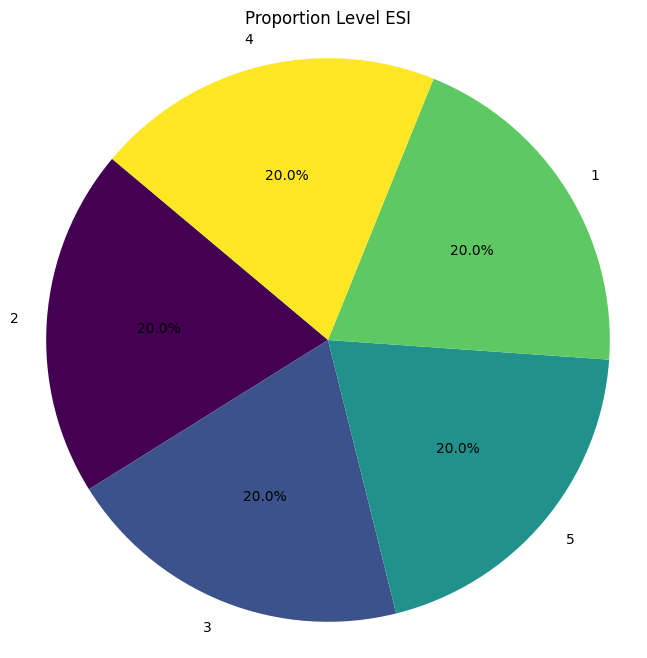

In [33]:
import matplotlib.cm as cm

# Hitung proporsi setiap kelas
esi_counts = df_copy['level_esi'].value_counts()

# Buat color map viridis
viridis = cm.get_cmap('viridis', len(esi_counts))

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(esi_counts, labels=esi_counts.index, autopct='%1.1f%%', startangle=140, colors=viridis(range(len(esi_counts))))
plt.title('Proportion Level ESI')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()